# Library

In [75]:
import numpy as np
import pandas as pd
import os
import glob
import random
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler

import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

# warning 무시
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Load

feature 중 ["펌프작동남은시간.1", "외부온도추정관측치" , "외부습도추정관측치", "펌프최근분무량", "펌프일간누적분무량] columns가 미세한 이름 차이로 다름

-> ["펌프작동남은시간", "펌프최근분류량", "펌프일간누적분뮤량", "외부온도관측치", 외부습도관측치"]로 통일

In [44]:
features =['시간', '내부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치', '외부온도관측치', '외부습도관측치',
       '펌프상태', '펌프작동남은시간', '펌프최근분무량', '펌프일간누적분무량', '냉방상태', '냉방작동남은시간', '난방상태',
       '난방작동남은시간', '내부유동팬상태', '내부유동팬작동남은시간', '외부환기팬상태', '외부환기팬작동남은시간',
       '화이트 LED상태', '화이트 LED작동남은시간', '화이트 LED동작강도', '레드 LED상태', '레드 LED작동남은시간',
       '레드 LED동작강도', '블루 LED상태', '블루 LED작동남은시간', '블루 LED동작강도', '카메라상태', '냉방온도',
       '난방온도', '기준온도', '난방부하', '냉방부하', '총추정광량', '백색광추정광량', '적색광추정광량',
       '청색광추정광량']

In [45]:
def inputdataload(data_dir, file_name):
  file_path = os.path.join(data_dir, file_name)
  csv_names = sorted(os.listdir(file_path))
  
  input = pd.DataFrame()
  for csv in csv_names:
    df = pd.read_csv(os.path.join(file_path, csv))
    df.columns = features
    input = pd.concat([input, df], axis=0)
  
  return input

In [24]:
def targetdataload(data_dir, file_name):
  file_path = os.path.join(data_dir, file_name)
  csv_names = sorted(os.listdir(file_path))

  target = pd.DataFrame()
  for csv in csv_names:
    df = pd.read_csv(os.path.join(file_path, csv))
    target = pd.concat([target, df], axis=0)

  return target

## Train Input

In [33]:
data_dir = '/content/drive/My Drive/BokChoy'
file_name = 'train_input'
train_input = inputdataload(data_dir, file_name)
train_input.sample(3)

,시간,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,펌프최근분무량,...,카메라상태,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
27462,2022-05-15 01:42:00,22.0,87.000000,712.0,3.328675,20.220000,31.819999,0.0,0.0,769.0,...,0.0,21.000000,20.000000,20.500000,0.0,9.499998,0.0000,0.0000,0.0000,0.0
2359,2022-04-27 15:19:00,27.4,42.299999,590.0,3.628563,24.620000,20.200001,0.0,0.0,769.0,...,0.0,26.000000,25.000000,25.500000,0.0,10.000000,350.7800,309.4100,41.3700,0.0
25616,2022-05-13 18:56:00,24.9,85.400002,411.0,3.213334,24.080001,28.880000,0.0,0.0,769.0,...,0.0,23.649258,22.649258,23.149258,0.0,13.253788,23.3135,21.6587,1.6548,0.0


## Train Target

In [32]:
data_dir = '/content/drive/My Drive/BokChoy'
file_name = 'train_target'
train_target = targetdataload(data_dir, file_name)
train_target.sample(3)

,시간,rate
11,2021-04-29 00:00:00,0.23214
21,2022-04-30 00:00:00,0.13724
21,2021-09-24 00:00:00,0.01725


## Test Input

In [63]:
data_dir = '/content/drive/My Drive/BokChoy'
file_name = 'test_input'
test_input = inputdataload(data_dir, file_name)
test_input.sample(3)

,시간,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,펌프최근분무량,...,카메라상태,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
23459,2022-03-24 06:59:00,17.200001,71.300003,444.0,1.983736,NaN,NaN,0.0,0.0,61.70,...,0.0,16.499403,11.499403,13.999403,0.0,28.002948,161.402,148.5168,6.6192,6.266
51803,2022-05-17 23:23:00,22.100000,83.699997,833.0,0.000000,23.54,39.400002,0.0,0.0,769.00,...,0.0,16.000000,14.000000,15.000000,0.0,40.500002,0.000,0.0000,0.0000,0.000
21409,2022-03-22 20:49:00,23.100000,74.800003,679.0,2.916925,NaN,NaN,0.0,0.0,55.27,...,0.0,15.000000,10.000000,12.500000,0.0,65.500002,0.000,0.0000,0.0000,0.000


## Test Target

In [30]:
data_dir = '/content/drive/My Drive/BokChoy'
file_name = 'test_target'
test_target = targetdataload(data_dir, file_name)
test_target.sample(3)

,시간,rate
29,2022-03-01 00:00:00,0
12,2021-05-08 00:00:00,0
14,2021-06-19 00:00:00,0


# EDA

In [34]:
train_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38880 entries, 0 to 38879
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   시간             38880 non-null  object 
 1   내부온도관측치        38878 non-null  float64
 2   내부습도관측치        38878 non-null  float64
 3   CO2관측치         38878 non-null  float64
 4   EC관측치          38878 non-null  float64
 5   외부온도관측치        38878 non-null  float64
 6   외부습도관측치        38878 non-null  float64
 7   펌프상태           38878 non-null  float64
 8   펌프작동남은시간       38878 non-null  float64
 9   펌프최근분무량        38878 non-null  float64
 10  펌프일간누적분무량      38878 non-null  float64
 11  냉방상태           38878 non-null  float64
 12  냉방작동남은시간       38878 non-null  float64
 13  난방상태           38878 non-null  float64
 14  난방작동남은시간       38878 non-null  float64
 15  내부유동팬상태        38878 non-null  float64
 16  내부유동팬작동남은시간    38878 non-null  float64
 17  외부환기팬상태        38878 non-null  float64
 18  외부환기팬작

In [35]:
train_input.describe()

,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,펌프최근분무량,펌프일간누적분무량,...,카메라상태,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
count,38878.000000,38878.000000,38878.000000,38878.000000,38878.000000,38878.000000,38878.000000,38878.000000,38878.0,38878.000000,...,38878.000000,38878.000000,38878.000000,38878.000000,38878.000000,38878.000000,38878.000000,38878.000000,38878.000000,38878.0
mean,24.593466,75.518499,543.429416,3.271167,22.651283,35.635168,2.466151,1.117856,769.0,6692.374904,...,0.170611,23.500117,22.500117,23.000117,0.370769,10.498369,167.785317,148.213312,19.719246,0.0
std,2.502072,13.048596,156.134843,1.073344,2.192105,6.439571,22.127283,10.251592,0.0,4200.266383,...,5.853589,2.357027,2.357027,2.357027,1.536289,3.789458,167.761229,150.753959,19.783492,0.0
min,19.500000,38.599998,215.000000,0.000000,16.600000,16.740000,0.000000,0.000000,769.0,769.000000,...,0.000000,21.000000,20.000000,20.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,22.200001,66.800003,401.000000,3.266491,21.260000,31.900000,0.000000,0.000000,769.0,2307.000000,...,0.000000,21.000000,20.000000,20.500000,0.000000,8.999996,0.000000,0.000000,0.000000,0.0
50%,24.400000,80.599998,583.000000,3.642605,22.900000,35.800000,0.000000,0.000000,769.0,6152.000000,...,0.000000,23.501281,22.501281,23.001281,0.000000,10.500002,115.343700,102.105300,13.238400,0.0
75%,27.100000,85.599998,667.000000,3.870280,24.200001,39.560000,0.000000,0.000000,769.0,10766.000000,...,0.000000,26.000000,25.000000,25.500000,0.000000,12.257606,350.780000,309.410000,41.370000,0.0
max,28.799999,95.800003,962.000000,4.030755,27.839999,53.084494,201.000000,119.000000,769.0,13842.000000,...,201.000000,26.000000,25.000000,25.500000,11.900005,24.499998,350.780000,5825.000000,41.370000,0.0


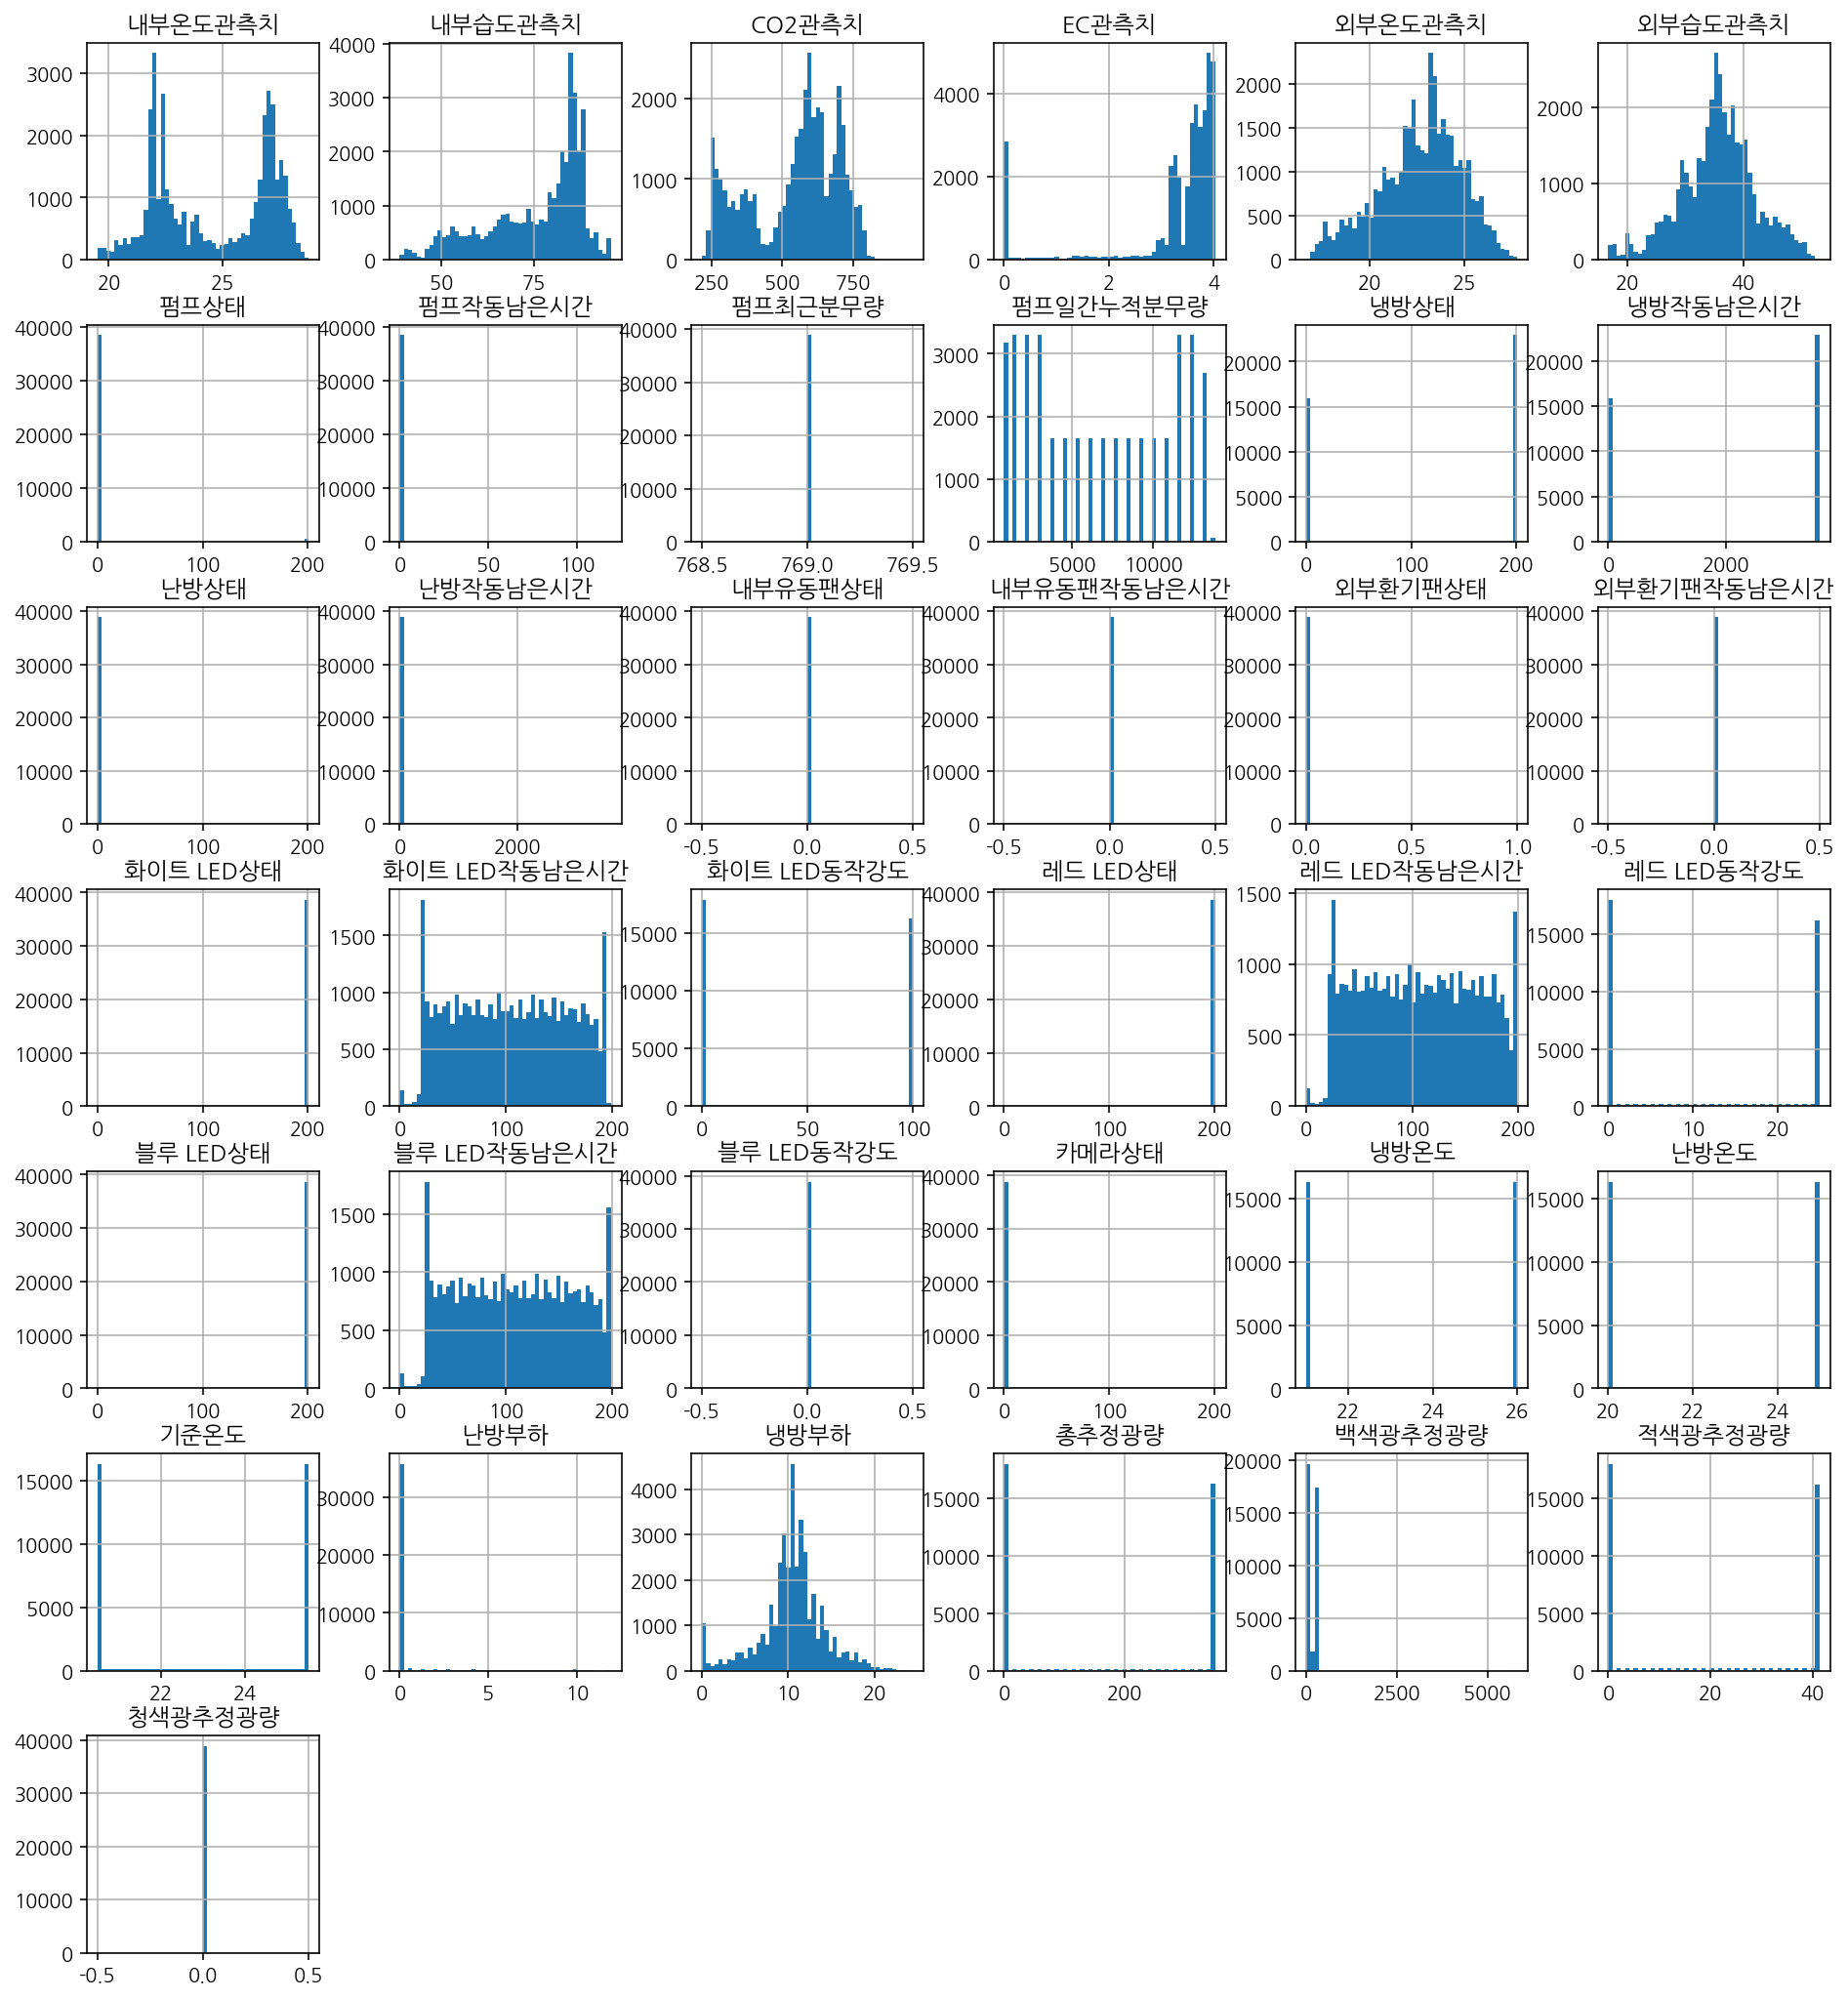

In [38]:
_=train_input.hist(figsize=(16,18), bins=50);

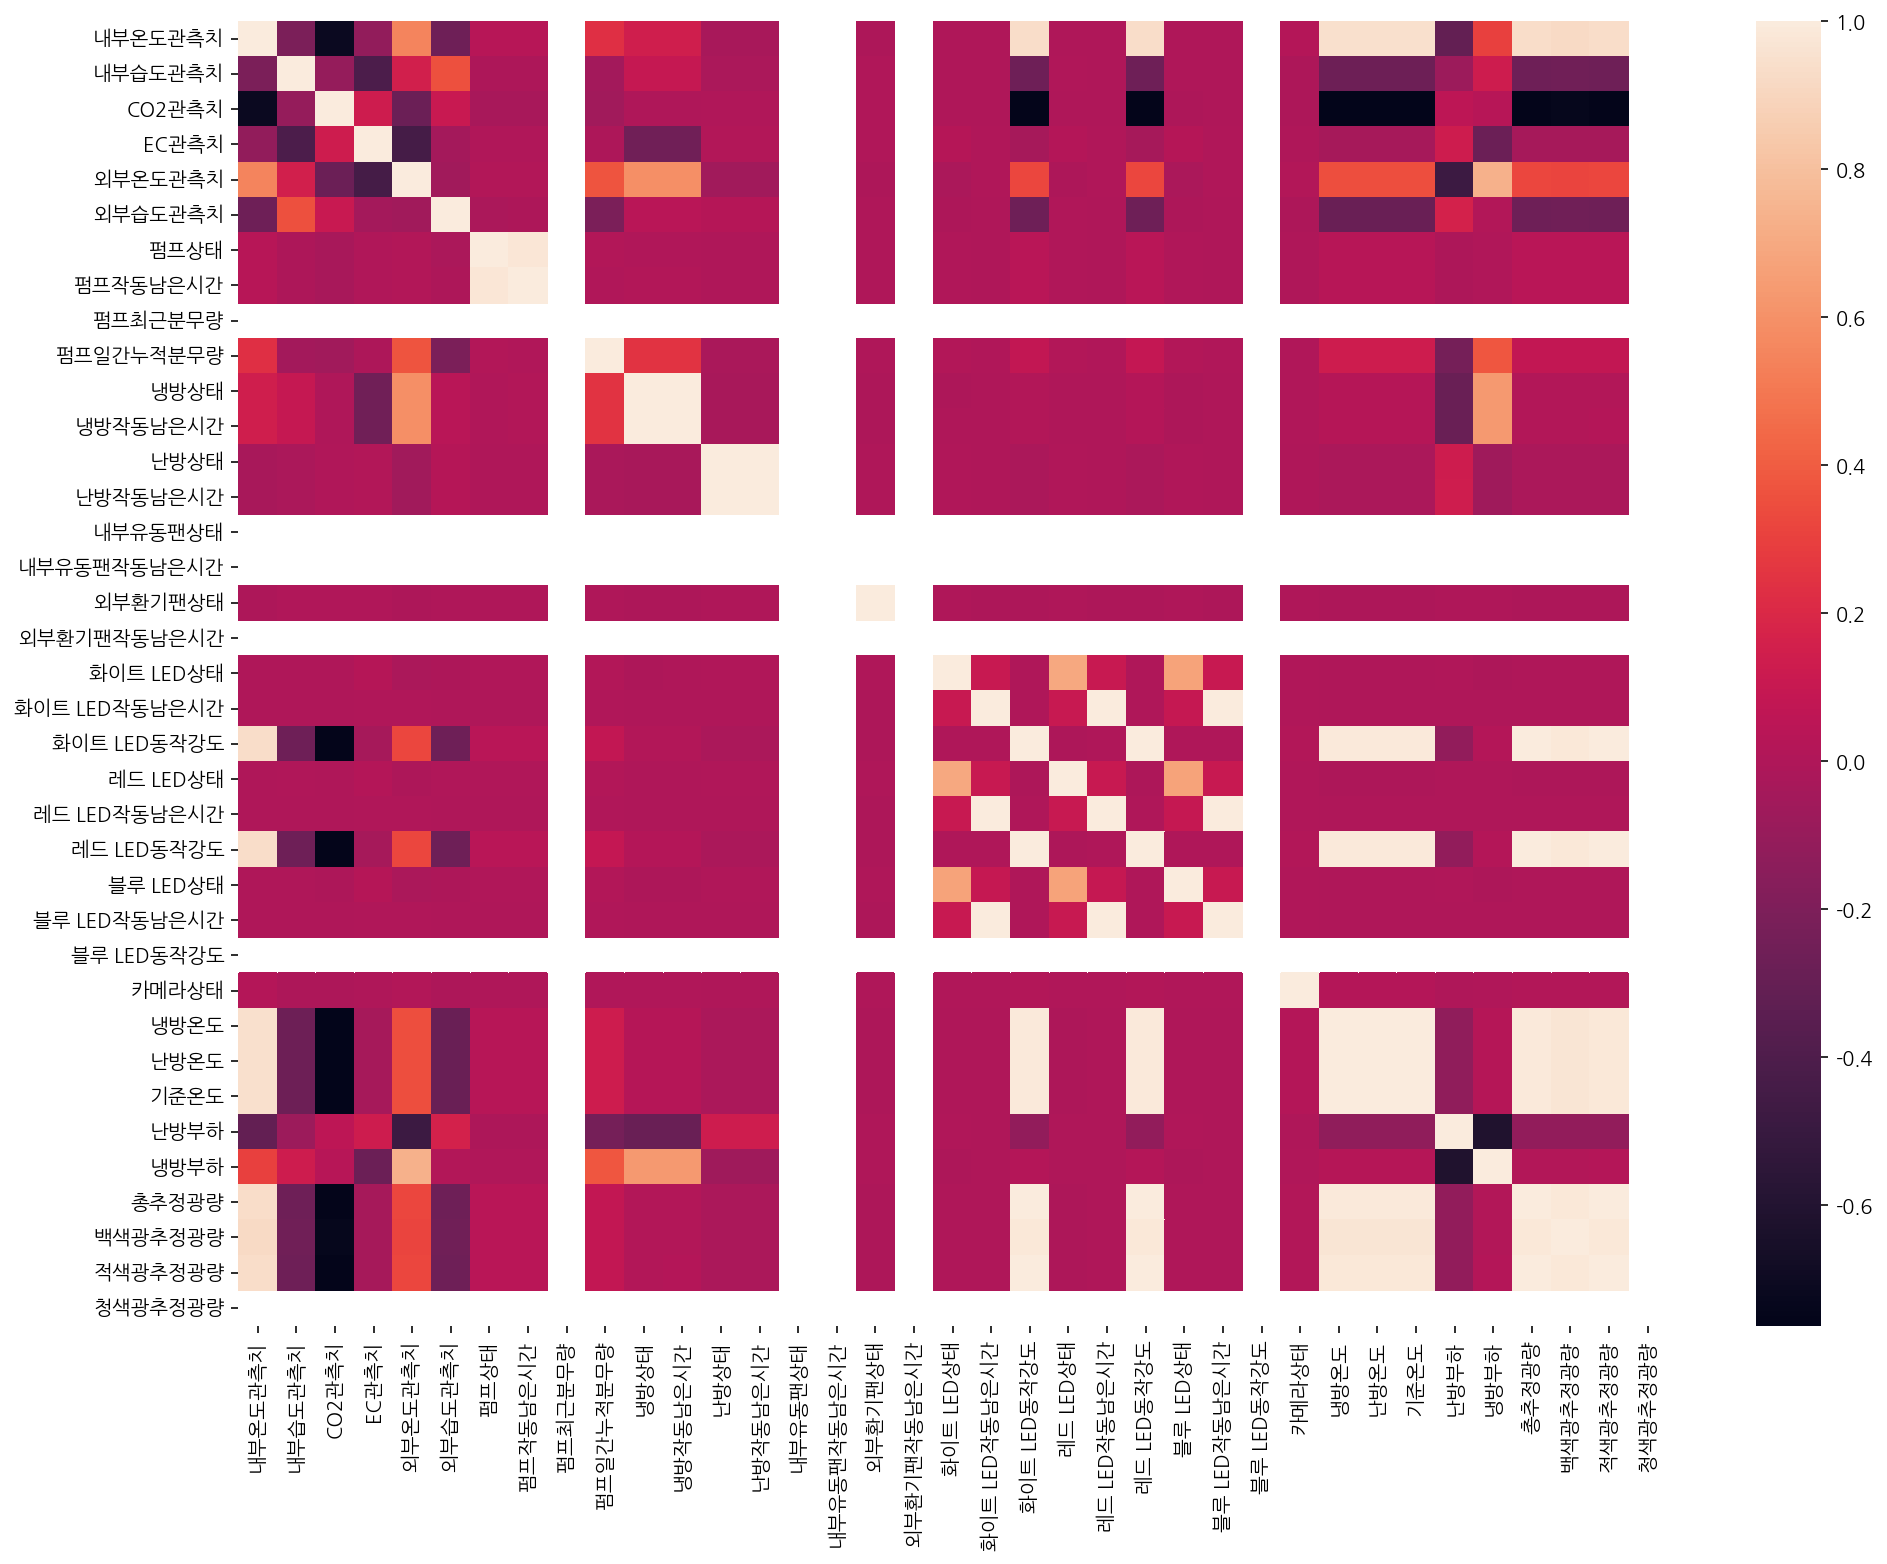

In [39]:
plt.figure(figsize=(16,12))
_=sns.heatmap(train_input.corr(), )

# Preprocessing

In [41]:
CFG = {
    'EPOCHS':5,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':16,
    'SEED':41
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [61]:
train_input_list = sorted(glob.glob('/content/drive/My Drive/BokChoy/train_input/*.csv'))
train_target_list = sorted(glob.glob('/content/drive/My Drive/BokChoy/train_target/*.csv'))
test_input_list = sorted(glob.glob('/content/drive/My Drive/BokChoy/test_input/*.csv'))
test_target_list = sorted(glob.glob('/content/drive/My Drive/BokChoy/test_target/*.csv'))

In [62]:
def preprocess_data(input_paths, target_paths):
    
    idx = 0
    
    temp_df = pd.DataFrame()
    for input_path, target_path in tqdm(zip(input_paths, target_paths)):
        
        idx+=1
        
        input_df = pd.read_csv(input_path) # input 
        target_df = pd.read_csv(target_path) # target 
        
        input_df.columns = features  # 
        
        input_df["시간"] = pd.to_datetime(input_df["시간"]) + datetime.timedelta(days=1)
        input_df["year"] = input_df["시간"].dt.year
        input_df["month"] = input_df["시간"].dt.month
        input_df["day"] = input_df["시간"].dt.day
        
        target_df["시간"] = pd.to_datetime(target_df["시간"]) 
        target_df["year"] = input_df["시간"].dt.year
        target_df["month"] = target_df["시간"].dt.month
        target_df["day"] = target_df["시간"].dt.day
        
        input_df = input_df.groupby(by=["year", "month", "day"]).median().reset_index()
        target_df = target_df.groupby(by=["year", "month", "day"]).median().reset_index()
        
        
        input_df["time"] = np.arange(0, len(input_df))
        input_df["case"] = idx
        df = pd.merge(input_df, target_df) # 시간 기준 rate 합쳐줌 
        temp_df = pd.concat([temp_df, df], axis=0)
        
    temp_df = temp_df.reset_index(drop=True)    
    return temp_df

train_df = preprocess_data(train_input_list, train_target_list)
test_df = preprocess_data(test_input_list, test_target_list)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [67]:
display(train_df.shape)
display(train_df.sample(3))
display(test_df.shape)
display(test_df.sample(3))

(1813, 41)

,year,month,day,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,...,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,rate
877,2021,10,3,24.299999,84.400002,538.0,1.559776,25.799999,59.150000,0.0,...,16.670714,14.001398,15.432666,0.0,46.821902,114.0211,99.0112,6.6192,6.2660,0.04187
940,2022,2,15,25.400000,72.599998,800.0,0.055847,24.020000,32.200000,0.0,...,18.008971,16.004304,17.006638,0.0,42.500000,170.8115,148.5168,11.5836,9.3990,0.31120
611,2021,7,1,24.849999,83.500000,468.5,0.237832,24.500000,57.700001,0.0,...,21.659682,19.659682,20.659682,0.0,26.130210,114.8633,99.0112,6.6192,4.6995,0.02222


(195, 41)

,year,month,day,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,...,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,rate
155,2022,4,11,23.700001,74.049999,444.0,0.00000,NaN,NaN,0.0,...,16.494988,11.494988,13.994988,0.0,60.000000,114.02110,102.10530,6.6192,6.26600,0.0
158,2022,4,14,21.500000,74.599998,472.0,2.27574,NaN,NaN,0.0,...,16.505345,11.505345,14.005345,0.0,39.315252,109.80105,97.46415,6.6192,5.48275,0.0
62,2021,5,29,24.200001,80.699997,512.5,0.00000,22.200001,54.599998,0.0,...,23.501937,22.501937,23.001937,0.0,8.000002,114.02110,99.01120,6.6192,4.69950,0.0


In [66]:
train_df = train_df.drop(columns=['time', 'case'])
test_df = test_df.drop(columns=['time', 'case'])

In [87]:
train_df.shape, test_df.shape

((1813, 41), (195, 41))

In [104]:
train_df = train_df.fillna(method='pad')
test_df = test_df.fillna(method='pad')

# Train/Test split

In [105]:
label_name = 'rate'

X_train = train_df.iloc[:,:-1]
y_train = train_df[label_name]
X_test = test_df.iloc[:,:-1]
y_test = test_df[label_name]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1813, 40), (1813,), (195, 40), (195,))

# Scaling

In [106]:
rbs = RobustScaler()
X_train_scaled = rbs.fit_transform(X_train)
X_test_scaled = rbs.transform(X_test)

In [107]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(X_train_scaled, y_train, test_size = 0.2)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape


((1450, 40), (363, 40), (1450,), (363,))

# Modeling

In [108]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape = [len(X_train.columns)]),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [109]:
model.compile(
    loss = 'mean_squared_error',
    metrics = 'RootMeanSquaredError',
    optimizer = 'adam'
)

In [110]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               5248      
                                                                 
 dense_11 (Dense)            (None, 512)               66048     
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dropout_8 (Dropout)         (None, 256)              

In [111]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500)
history = model.fit(x_train, y_train, epochs = 5000, validation_split = 0.1, callbacks= [early_stop])

Epoch 1/5000
41/41 [==============================] - 1s 12ms/step - loss: 78.8655 - root_mean_squared_error: 8.8806 - val_loss: 26744.9297 - val_root_mean_squared_error: 163.5388
Epoch 2/5000
41/41 [==============================] - 0s 9ms/step - loss: 17121.3477 - root_mean_squared_error: 130.8486 - val_loss: 2215.1899 - val_root_mean_squared_error: 47.0658
Epoch 3/5000
41/41 [==============================] - 0s 9ms/step - loss: 44.7890 - root_mean_squared_error: 6.6925 - val_loss: 11330.5771 - val_root_mean_squared_error: 106.4452
Epoch 4/5000
41/41 [==============================] - 0s 9ms/step - loss: 13702.7246 - root_mean_squared_error: 117.0586 - val_loss: 14276.7490 - val_root_mean_squared_error: 119.4854
Epoch 5/5000
41/41 [==============================] - 0s 9ms/step - loss: 623.3897 - root_mean_squared_error: 24.9678 - val_loss: 22433.2402 - val_root_mean_squared_error: 149.7773
Epoch 6/5000
41/41 [==============================] - 0s 9ms/step - loss: 2558.1189 - root_mea

# Predicticion & Submission

In [114]:
y_pred = model.predict(X_test_scaled)
y_pred.shape

7/7 [==============================] - 0s 6ms/step


(195, 1)

In [121]:
test_target['rate'] = y_pred
test_target

,시간,rate
0,2022-01-31 00:00:00,0.295953
1,2022-02-01 00:00:00,0.295953
2,2022-02-02 00:00:00,0.295953
3,2022-02-03 00:00:00,0.295953
4,2022-02-04 00:00:00,0.295953
...,...,...
31,2022-05-14 00:00:00,0.295953
32,2022-05-15 00:00:00,0.262964
33,2022-05-16 00:00:00,0.266864
34,2022-05-17 00:00:00,0.215959


In [167]:
path = "/content/drive/My Drive/BokChoy/sample_submission"
sub_list = sorted(os.listdir(path))
length = 0
for i, sub in enumerate(sub_list):
  sub = pd.read_csv(f'{path}/{sub}', index_col='시간')
  sub['rate'] = y_pred[length:length+len(sub)]
  length += len(sub)
  sub.to_csv(f'sample_submission/TEST_0{i+1}.csv', index='시간')


In [165]:
for i in sub_list:
  data = pd.read_csv(i)
  print(data)

                     시간      rate
0   2021-03-27 00:00:00  0.295953
1   2021-03-28 00:00:00  0.295953
2   2021-03-29 00:00:00  0.295953
3   2021-03-30 00:00:00  0.295953
4   2021-03-31 00:00:00  0.295953
5   2021-04-01 00:00:00  0.295953
6   2021-04-02 00:00:00  0.295953
7   2021-04-03 00:00:00  0.295953
8   2021-04-04 00:00:00  0.295953
9   2021-04-05 00:00:00  0.295953
10  2021-04-06 00:00:00  0.295953
11  2021-04-07 00:00:00  0.295953
12  2021-04-08 00:00:00  0.295953
13  2021-04-09 00:00:00  0.295953
14  2021-04-10 00:00:00  0.295953
15  2021-04-11 00:00:00  0.295953
16  2021-04-12 00:00:00  0.295953
17  2021-04-13 00:00:00  0.295953
18  2021-04-14 00:00:00  0.295953
19  2021-04-15 00:00:00  0.295953
20  2021-04-16 00:00:00  0.295953
21  2021-04-17 00:00:00  0.295953
22  2021-04-18 00:00:00  0.295953
23  2021-04-19 00:00:00  0.295953
24  2021-04-20 00:00:00  0.295953
25  2021-04-21 00:00:00  0.295953
26  2021-04-22 00:00:00  0.295953
27  2021-04-23 00:00:00  0.295953
28  2021-04-24